<a href="https://colab.research.google.com/github/i-osipchyk/insurance-cross-selling/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Ingestion

If using Google Colab, upload kaggle.json file to the environment. Then run these commands:

In [6]:
!cd /
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!cd content
!kaggle competitions download -c playground-series-s4e7
!unzip playground-series-s4e7.zip
!rm playground-series-s4e7.zip

 92% 228M/247M [00:01<00:00, 216MB/s]
100% 247M/247M [00:01<00:00, 216MB/s]


In [8]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## EDA

### Data Description

In [9]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [10]:
print('Shape of the training data:', train.shape)
print('Shape of the testing data:', test.shape)

Shape of the training data: (11504798, 12)
Shape of the testing data: (7669866, 11)


In [11]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


Let's drop id column from training set and save it from testing set, because we are not going to use them for the predictions.

In [12]:
train.drop('id', axis=1, inplace=True)
test_id = test['id']
test.drop('id', axis=1, inplace=True)

In [13]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Feature Distributions

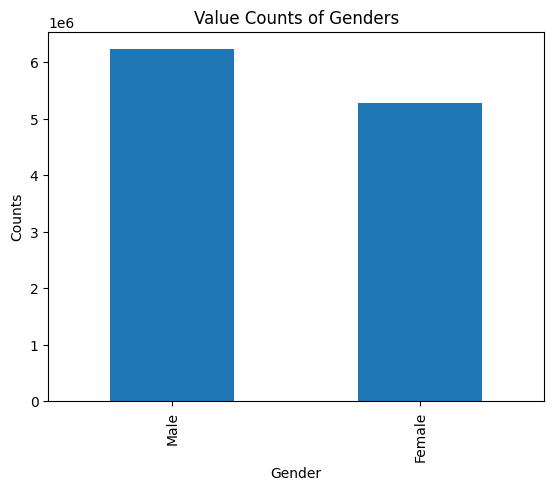

In [18]:
train['Gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Value Counts of Genders')
plt.show()

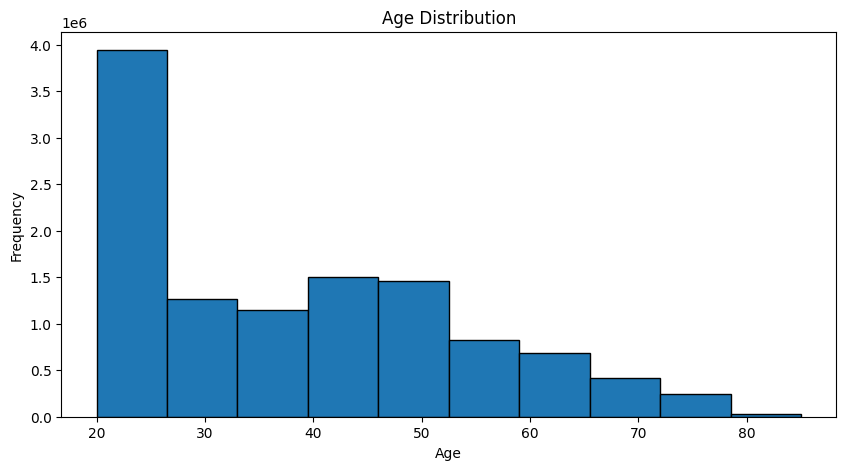

In [19]:
plt.figure(figsize=(10, 5))
plt.hist(train['Age'], bins=10, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

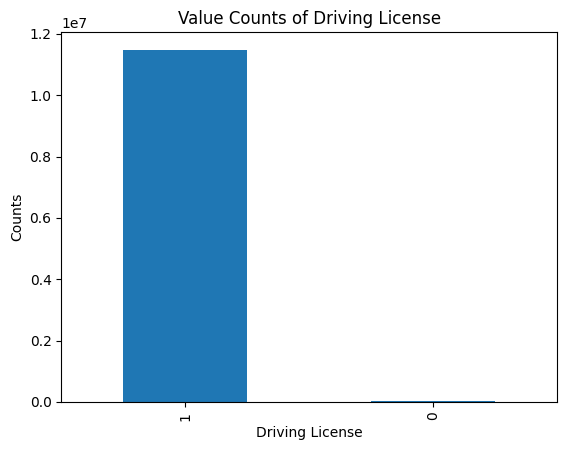

In [68]:
train['Driving_License'].value_counts().plot(kind='bar')
plt.xlabel('Driving License')
plt.ylabel('Counts')
plt.title('Value Counts of Driving License')
plt.show()

Note that number of instances without driving license is very underrepresented.

In [21]:
train['Driving_License'].value_counts()

Driving_License
1    11482041
0       22757
Name: count, dtype: int64

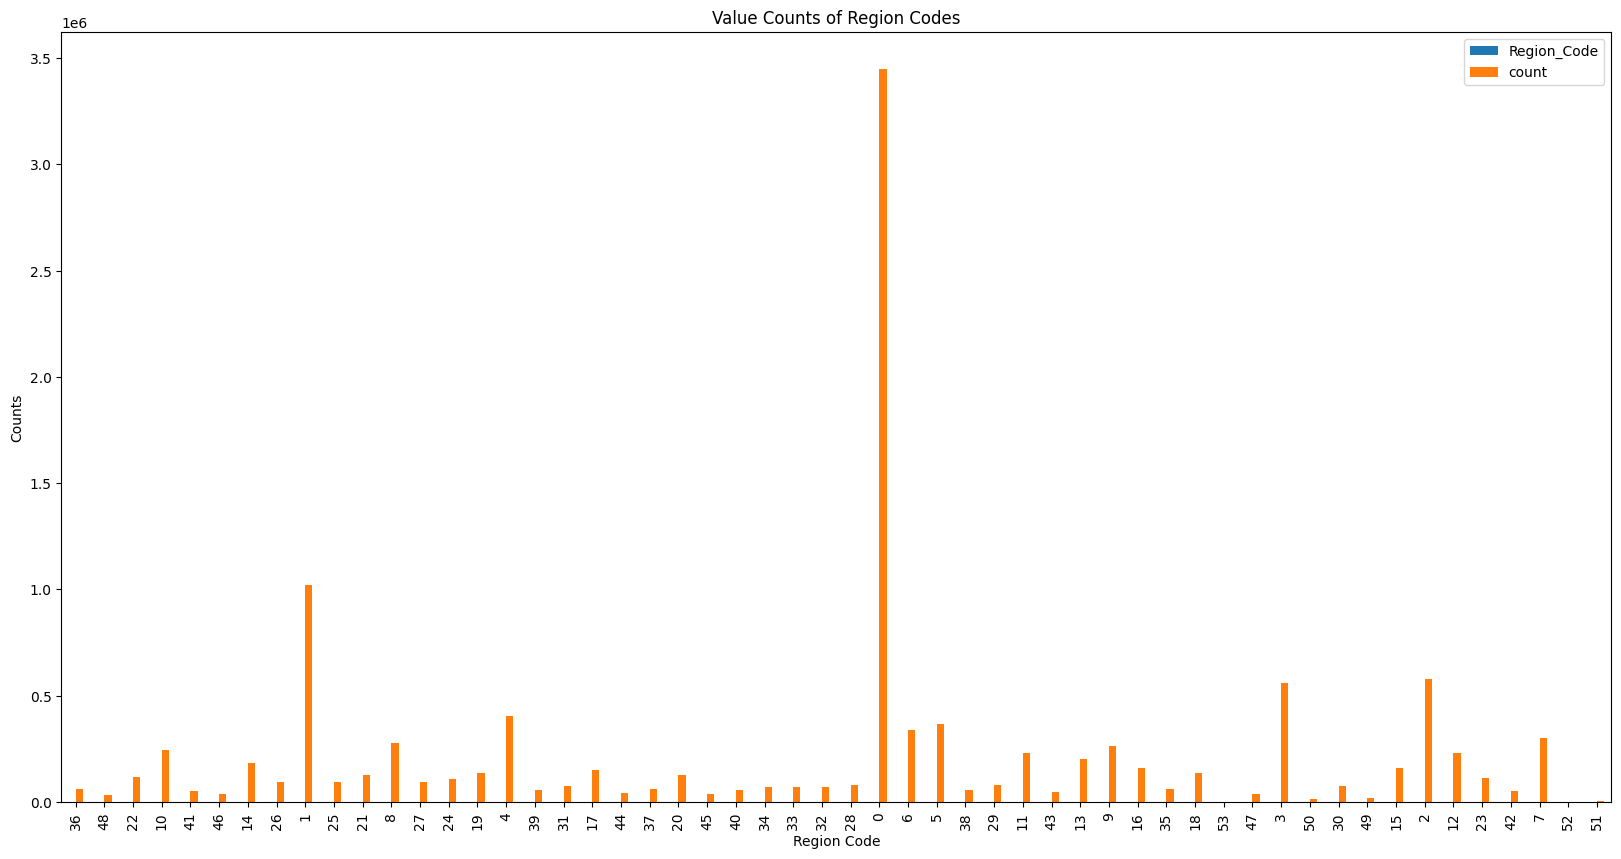

In [28]:
plt.figure(figsize=(20, 10))
ax = plt.gca()
train['Region_Code'].value_counts().reset_index().sort_values(by='Region_Code').plot(kind='bar', ax=ax)
plt.xlabel('Region Code')
plt.ylabel('Counts')
plt.title('Value Counts of Region Codes')
plt.show()

Almost thirrd of instances if from Region with code 0.

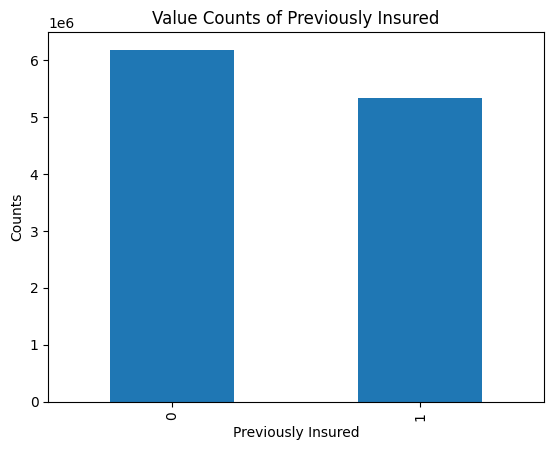

In [45]:
train['Previously_Insured'].value_counts().plot(kind='bar')
plt.xlabel('Previously Insured')
plt.ylabel('Counts')
plt.title('Value Counts of Previously Insured')
plt.show()

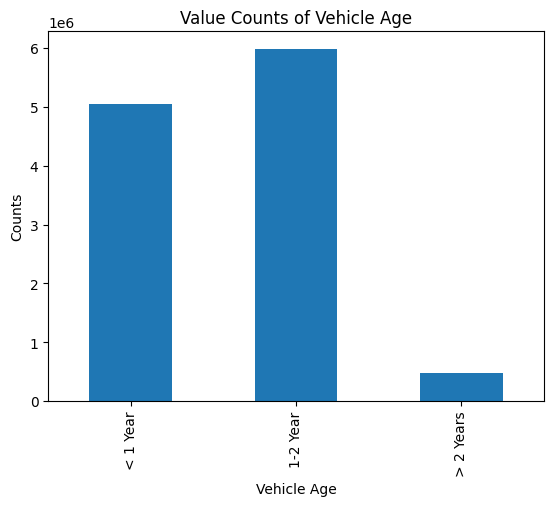

In [44]:
new_order = [1, 0, 2]
v_age_dist = train['Vehicle_Age'].value_counts().reset_index()
v_age_dist['Order'] = new_order
v_age_dist.sort_values(by='Order', ascending=True, inplace=True)
v_age_dist.set_index('Vehicle_Age', inplace=True)
v_age_dist['count'].plot(kind='bar')
plt.xlabel('Vehicle Age')
plt.ylabel('Counts')
plt.title('Value Counts of Vehicle Age')
plt.show()

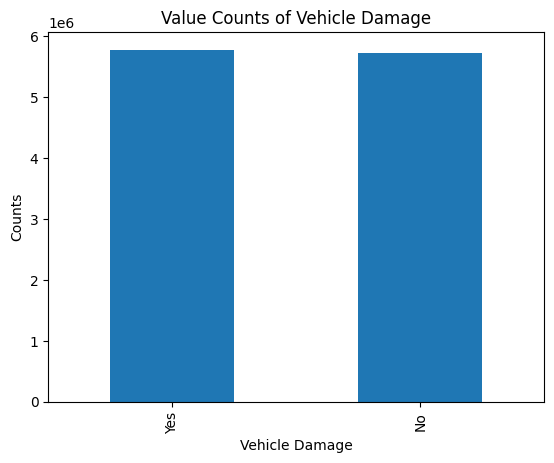

In [47]:
train['Vehicle_Damage'].value_counts().plot(kind='bar')
plt.xlabel('Vehicle Damage')
plt.ylabel('Counts')
plt.title('Value Counts of Vehicle Damage')
plt.show()

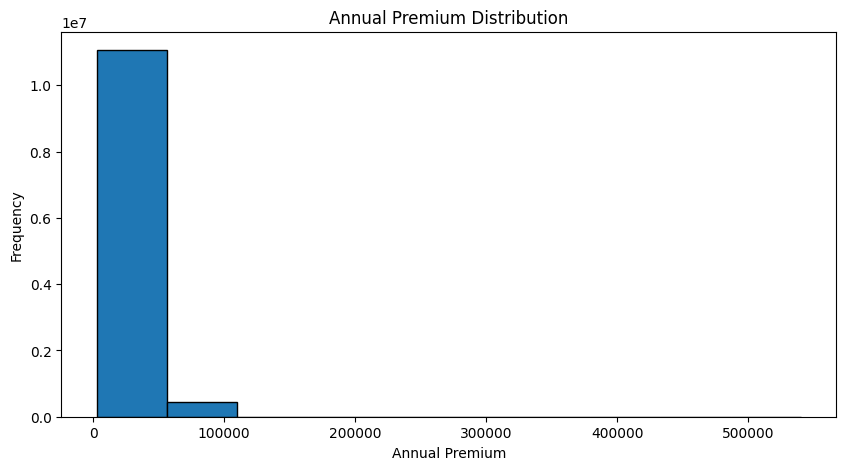

In [49]:
plt.figure(figsize=(10, 5))
plt.hist(train['Annual_Premium'], bins=10, edgecolor='black')
plt.xlabel('Annual Premium')
plt.ylabel('Frequency')
plt.title('Annual Premium Distribution')
plt.show()

There are some values that are higher than 100000. We can consider them as outliers and delete them Let's check what is their percentage to make sure if it's the right thing to do.

In [70]:
print(
    "Precentage of instances with Annual Premium more than 100000: {:.4f}"
    .format(len(train.query("Annual_Premium > 100000"))/len(train)*100)
    )

Precentage of instances with Annual Premium more than 100000: 0.0000


The percentage is very low, so we will drop them.

In [71]:
train = train[train['Annual_Premium'] <= 100000]

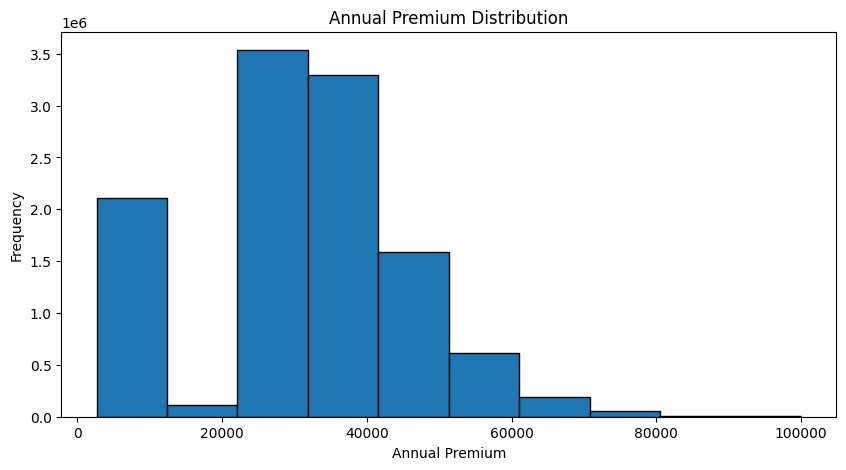

In [64]:
plt.figure(figsize=(10, 5))
plt.hist(train['Annual_Premium'], bins=10, edgecolor='black')
plt.xlabel('Annual Premium')
plt.ylabel('Frequency')
plt.title('Annual Premium Distribution')
plt.show()

Note a gap between 10000 and 20000.

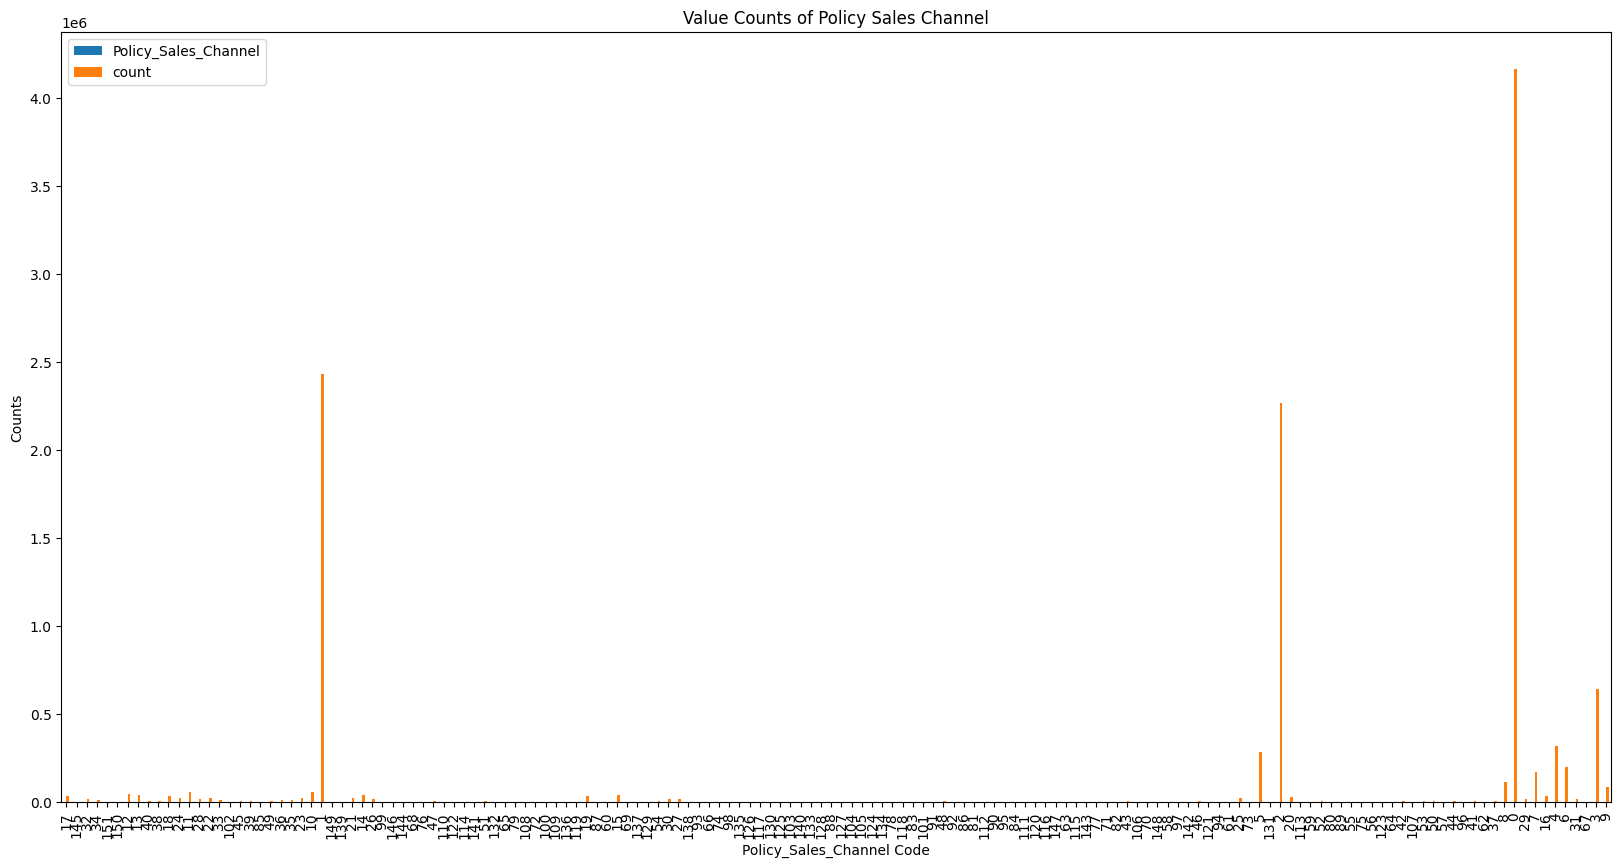

In [65]:
plt.figure(figsize=(20, 10))
ax = plt.gca()
train['Policy_Sales_Channel'].value_counts().reset_index().sort_values(by='Policy_Sales_Channel').plot(kind='bar', ax=ax)
plt.xlabel('Policy_Sales_Channel Code')
plt.ylabel('Counts')
plt.title('Value Counts of Policy Sales Channel')
plt.show()

Same as was with region, some values are mentioned many times, and some almost never. That can affect our model.

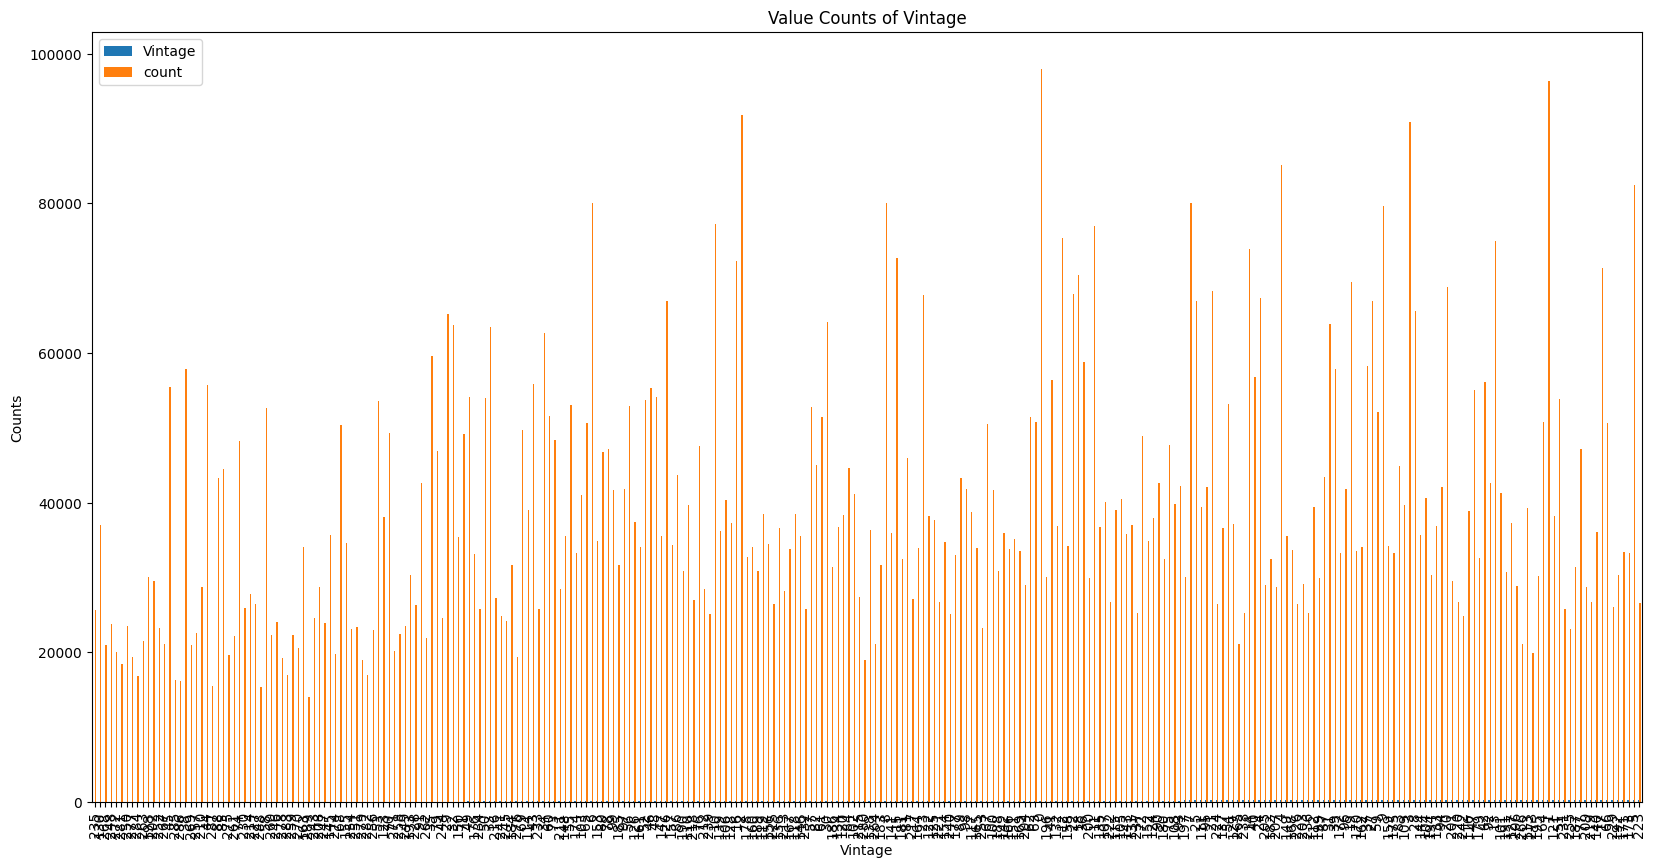

In [66]:
plt.figure(figsize=(20, 10))
ax = plt.gca()
train['Vintage'].value_counts().reset_index().sort_values(by='Vintage').plot(kind='bar', ax=ax)
plt.xlabel('Vintage')
plt.ylabel('Counts')
plt.title('Value Counts of Vintage')
plt.show()

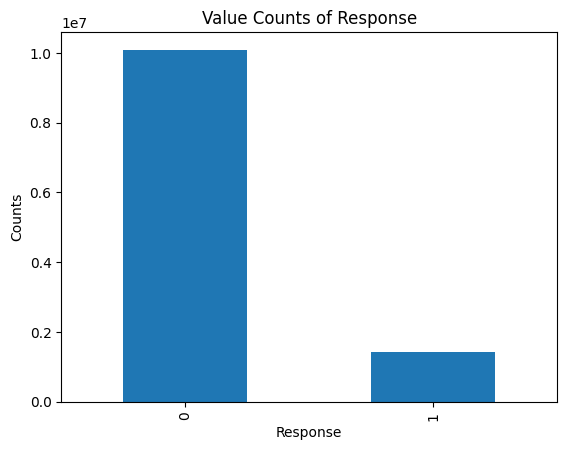

In [67]:
train['Response'].value_counts().plot(kind='bar')
plt.xlabel('Response')
plt.ylabel('Counts')
plt.title('Value Counts of Response')
plt.show()

Note that class 1 is highly underrepresented. We may want to apply oversampling later.